In [1]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf

from drn_interactions.load import load_spikes, load_neurons, load_clusters
from drn_interactions.transforms import bin_spikes
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import variation
from spiketimes.df.statistics import mean_firing_rate_by, cv2_isi_by


In [2]:
df_spikes = load_spikes("pre")
neurons = load_neurons()
clusters = load_clusters()

In [3]:
neurons_subset = neurons.loc[lambda x: x.mean_firing_rate > 0.1]["neuron_id"].sample(100)
max_time = 1200
bin_width = 0.1
df = df_spikes.loc[lambda x: (x.neuron_id.isin(neurons_subset)) & (x.spiketimes < max_time)].copy()
df = bin_spikes(df, bin_width=bin_width, t_before=0, t_max=max_time)

In [42]:
start = 0
stop = 1800
step = 1

starts = np.arange(start, stop, step)

dfs = []
for t_start, t_stop in zip(starts, starts[1:]):
    df_spikes_sub = df_spikes.loc[lambda x: (x.spiketimes > t_start) & (x.spiketimes < t_stop)]
    mfr = mean_firing_rate_by(df_spikes_sub, spiketrain_col="neuron_id")
    cv = cv2_isi_by(df_spikes_sub, spiketrain_col="neuron_id")
    df = mfr.merge(cv).assign(t_start=t_start, t_stop=t_stop)
    dfs.append(df)

df_ts = pd.concat(dfs)

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.ty

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:1144: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


<AxesSubplot:xlabel='t_start', ylabel='neuron_id'>

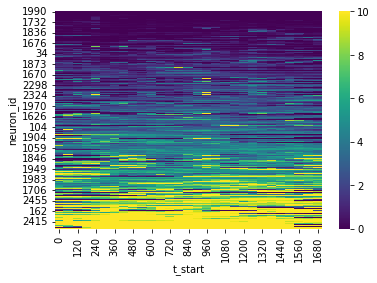

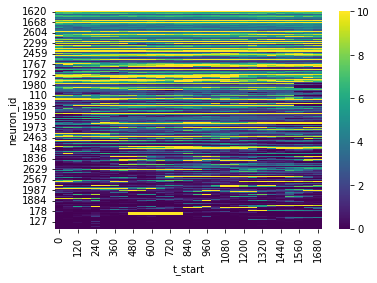

In [35]:
dfp = df_ts.pivot(index="t_start", columns="neuron_id", values="mean_firing_rate").fillna(0)

plt.figure()
idx = dfp.mean().sort_values().index.values
sns.heatmap(dfp[idx].transpose(), cmap="viridis", vmin=0, vmax=10)

plt.figure()
idx = dfp.apply(variation).sort_values().fillna(0).index.values
sns.heatmap(dfp[idx].transpose(), cmap="viridis", vmin=0, vmax=10)


<AxesSubplot:xlabel='t_start', ylabel='neuron_id'>

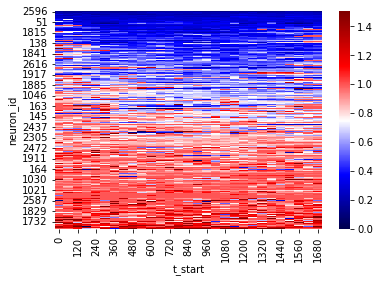

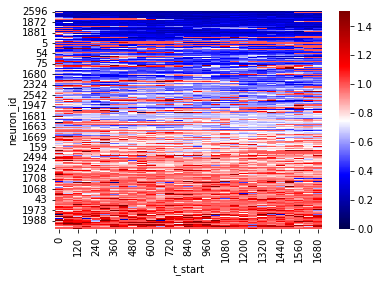

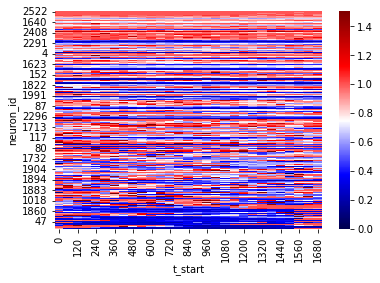

In [36]:
dfp = df_ts.pivot(index="t_start", columns="neuron_id", values="cv2_isi").fillna(1)

plt.figure()

idx = dfp.mean().sort_values().index.values
sns.heatmap(dfp[idx].transpose(), cmap="seismic", vmin=0, vmax=1.5)

idx = neurons.loc[neurons["neuron_id"].isin(dfp.columns)].sort_values("cv2_isi").neuron_id.values
plt.figure()
sns.heatmap(dfp[idx].transpose(), cmap="seismic", vmin=0, vmax=1.5)


plt.figure()
idx = dfp.apply(variation).sort_values().fillna(0).index.values
sns.heatmap(dfp[idx].transpose(), cmap="seismic", vmin=0, vmax=1.5)

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [40]:
df_cv = df_ts.pivot(index="t_start", columns="neuron_id", values="cv2_isi").fillna(1)
cv = df_cv.apply(variation).to_frame("cv_volitility").reset_index()

df_mfr = df_ts.pivot(index="t_start", columns="neuron_id", values="mean_firing_rate").fillna(0)
mfr = df_mfr.apply(variation).to_frame("mfr_volitility").fillna(1).reset_index()

df_vol = neurons[["neuron_id", "cv2_isi", "mean_firing_rate"]].merge(cv).merge(mfr).merge(clusters).set_index("neuron_id")

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:1144: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


(0.0, 2.0)

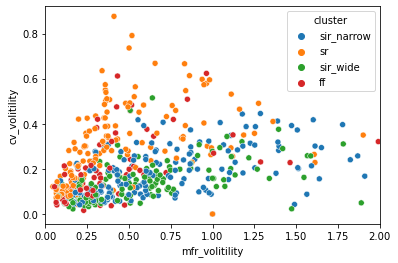

In [41]:
import seaborn as sns

ax = sns.scatterplot(data=df_vol.merge(clusters), x="mfr_volitility", y="cv_volitility", color="black", hue="cluster")
ax.set_xlim(0, 2)

<AxesSubplot:xlabel='cluster', ylabel='mfr_volitility'>

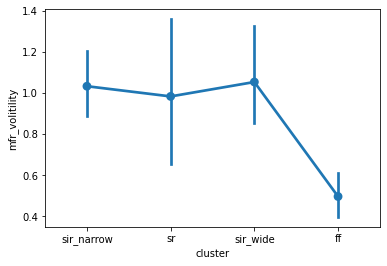

In [31]:
sns.pointplot(data=df_vol.merge(clusters), x="cluster", y="mfr_volitility")

In [14]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression


In [15]:
load_clusters()

,neuron_id,cluster
0,1,sir_narrow
1,4,sir_narrow
2,5,sir_narrow
3,6,sir_narrow
4,8,sr
...,...,...
537,2627,sir_narrow
538,2628,sir_narrow
539,2629,sir_narrow
540,2630,ff


In [17]:
df_vol

,cv2_isi,mean_firing_rate,cv_volitility,mfr_volitility,Unnamed: 0,cluster
neuron_id,,,,,,
1,0.467315,0.601693,0.303818,2.592713,0,sir_narrow
4,0.824797,2.105512,0.129536,1.605929,1,sir_narrow
5,0.394575,1.778190,0.384355,1.513739,2,sir_narrow
6,0.428821,0.832163,0.435585,1.119179,3,sir_narrow
8,0.305202,1.690391,0.597175,0.973183,4,sr
...,...,...,...,...,...,...
2627,1.032022,0.916395,0.301757,0.683792,537,sir_narrow
2628,1.250412,0.429663,0.351093,1.574283,538,sir_narrow
2629,0.840159,2.536273,0.348975,0.910227,539,sir_narrow


In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.

In [28]:
X = df_vol.copy()[["cv_volitility", "mfr_volitility", "cluster"]]

le = LabelEncoder()
y = le.fit_transform(X.pop("cluster"))

cross_val_score(DecisionTreeClassifier(max_depth=5), X, y, scoring="accuracy", cv=StratifiedKFold(shuffle=True, n_splits=3))

array([0.52222222, 0.51666667, 0.39664804])

In [163]:


# X = df_vol[["cv2_isi", "cv_volitility"]].copy()
X = df_vol.copy()
y = X.pop("cv_volitility")


cross_val_score(LinearRegression(), X, y, scoring="r2", cv=KFold(shuffle=True, n_splits=3))

array([0.36351915, 0.29895018, 0.27349175])

In [166]:
from scipy.stats import pearsonr

pearsonr(df_vol["cv2_isi"], df_vol["cv_volitility"])

(-0.5058624733539655, 7.562793388481347e-38)

<AxesSubplot:ylabel='neuron_id'>

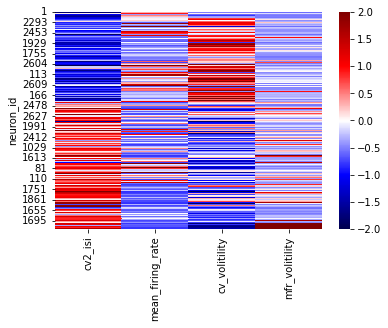

In [132]:
pipe = make_pipeline(StandardScaler(), KMeans(3))

pipe.fit(df_vol)


clusters = pipe.fit_predict(df_vol)

scaled = pd.DataFrame(StandardScaler().fit_transform(df_vol), index=df_vol.index, columns=df_vol.columns)



# clusters = KMeans(3).fit_predict(scaled)
sns.heatmap(scaled.iloc[np.argsort(clusters)], vmin=-2, vmax=2, cmap="seismic")

# print(df_vol.shape)
# print(scaled.shape)

In [130]:
scaled.iloc[np.argsort(clusters)]

,cv2_isi,mean_firing_rate,cv_volitility,mfr_volitility
neuron_id,,,,
1,-0.877278,-0.659682,0.322786,0.830049
2359,-1.805491,-0.010915,-0.262646,-0.562909
1658,-0.862888,-0.290263,-0.572779,-0.520658
2354,-1.817847,0.319839,-0.500333,-0.567073
1660,-1.275819,0.063844,-0.315842,-0.475916
...,...,...,...,...
1064,2.746151,-0.798906,-1.738101,6.796640
120,-0.593083,-0.540917,-1.352152,5.635662
1848,0.902944,-0.792601,-1.602210,4.464438


In [129]:
np.argsort(clusters)

array([  0, 431, 205, 430, 207, 429, 428, 210, 211, 427, 425, 423, 422,
       421, 420, 419, 418, 417, 415, 413, 412, 411, 410, 230, 231, 409,
       407, 406, 405, 404, 435, 439, 443, 445, 140, 485, 484, 143, 483,
       482, 146, 147, 149, 480, 479, 477, 476, 473, 403, 158, 160, 468,
       465, 464, 463, 340, 171, 460, 456, 454, 183, 451, 447, 446, 472,
       138, 402, 395, 303, 304, 305, 307, 308, 309, 311, 312, 358, 314,
       315, 316, 317, 357, 319, 356, 321, 354, 327, 329, 349, 331, 347,
       346, 335, 336, 345, 344, 339, 302, 361, 300, 299, 390, 253, 388,
       387, 386, 385, 384, 261, 262, 379, 266, 378, 268, 377, 400, 272,
       274, 275, 276, 278, 560, 281, 284, 285, 286, 287, 366, 293, 296,
       362, 273, 134, 170, 132, 536,  52,  53,  54, 533, 532, 530, 529,
       528,  63, 527,  66, 133,  70,  72, 521,  74,  93, 512,  89,  85,
       516, 517, 539, 518,  80, 519,  78,  77, 520,  75,  81,  47,  46,
        45,  18,  17, 552, 553, 554,  13,  19,  12, 556,   7,   